In [2]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

# Loading your IBM Q account(s)
IBMQ.save_account('719b7722bd337dd7962261f7ab63aecf65ea103e52134542217565cca62f70711cf23cb36b3ef283849558b844d4f4f6394e311dcc490b458bf4779592888289')
provider = IBMQ.load_account()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-99iwfpdv because the default path (/home/jupyter-ana/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
configrc.store_credentials:WARNING:2021-07-24 00:40:56,766: Credentials already present. Set overwrite=True to overwrite.


## Sudoku Solver

Let's look at a very basic implementation of the Grover algorithm: solving an NP-C problems! In this case, the problem is going to be a 2x2 binary sudoku. Obviously, solving a problem of this size is trivial (you can do it in your head) and most definitely not NP-hard (at least not until it gets larger) but the steps are valuable in forming an understanding of how oracles are created to solve problems.

Let's take a look at at the Sudoku grid and constraints. Each square is assigned a variable, $V_1, V_2, V_3, V_4$:

![](images/sudoku.PNG)

And we specify that: 
- No column may contain the same value twice
- No row may contain the same value twice

We need to create a quantum circuit that implements an oracle checking function. The 4 conditions you need to check are: 

- v0 ≠ v1   # check along top row
- v2 ≠ v3   # check along bottom row
- v0 ≠ v2   # check down left column
- v1 ≠ v3   # check down right column

First, create a clause list that holds the indices of the pair of variables you need to check:


In [3]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. Do do this, first you will need to create a quantum circuit consisting of quantum bits. You can initialize these using the following code:

- OBJ_QUANTUM = **QuantumRegister(SIZE, name='')**

OBJ_ is replaced with an object name of your choice, SIZE represents the number of qubits in the register. All qubits are initialized to the $|0\rangle$ state.
    
A quantum circuit is create by joining registers together together with:

OBJ_QC= **QuantumCircuit(OBJ_QUANTUM, OBJ_QUANTUM2)**

Since you will be performing 4 checks total for this circuit, and storing the result of each check in a new qubit, how many qubits do you need? 

In [ ]:
SIZE = #YOUR CODE HERE#
SIZE2 = #YOUR CODE HERE#

var_qubits = QuantumRegister(SIZE, name='v')  # representing variable bits
clause_qubits = QuantumRegister(SIZE2, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)


Now, we need to create a simple two-qubit circuit that will check whether two qubits are equal to each other, and store the result in an output variable.
We can do this using the CNOT gate, which will flip the sign of the target qubit if the control qubit is a 1. The CNOT gate is created by calling the **cx** built-in function like so: 

**cx(CONTROL, TARGET)**

Where the CONTROL and TARGET qubits are specified by the user. We can create a simple function that uses these CNOT gates to check whether var1 == var2, and to store the result in a (classical) output qubit. 

In [5]:
# Create a simple function that implements this
def XOR(qc, a, b, output):
    
    qc.cx(a, output)
    qc.cx(b, output)

In [ ]:
## Let's see what this looks like. Creating a 2-qubit dummy circuit:

in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

Convince yourself that the output0 bit in the circuit below will only be flipped if input0 ≠ input1.

Next, the goal is to call this circuit a total of 4 times to check whether all the qubits identified in the clause list satisfy the conditions. 

- input_0 ≠ input_1   # check along top row
- input_2 ≠ input_3   # check along bottom row
- input_0 ≠ input_2   # check down left column
- input_1 ≠ input_3   # check down right column

In [ ]:
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

The final state of the bits c_0 through c_3 will be all 1 only if the states of v_0 through v_3 are solutions to the Sudoku.

To complete this circuit, we can add one more gate that will serve as a 3-input AND gate, setting a new bit OUT to 1 only if c_0, c_1, and c_2 are all 1. 

Let's rewrite the circuit from the start. 

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

After running the circuit, the state of the $out_0$ bit tells us if the assignment of the states for v_0...v_3 is a solution or not. $out_0$ = 0 means the assignment is not a solution, and $out_0$=1 means the assignment is a solution.

Now, we can implement the Grover algorithm. For the sake of time, the algorithm is not shown or explained in detail here. The algorithm is simple and can be scaled up to any circuit of any size: the important part is the work that we have done so far, which consists of creating the oracle! 

In [12]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    qc.mct(clause_qubits, output_qubit)
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
        
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s
        
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

qc.x(output_qubit)
qc.h(output_qubit)
qc.h(var_qubits)
sudoku_oracle(qc, clause_list, clause_qubits)
qc.append(diffuser(4), [0,1,2,3])
sudoku_oracle(qc, clause_list, clause_qubits)
qc.append(diffuser(4), [0,1,2,3])
qc.measure(var_qubits, cbits)
qc.draw(fold=-1)
    

┌───┐                                                                                     ┌────────┐                                                                                     ┌────────┐┌─┐         
    v_0: ┤ H ├──■─────────■──────────────────────────────────■─────────■───────────────────────────┤0       ├──■─────────■──────────────────────────────────■─────────■───────────────────────────┤0       ├┤M├─────────
         ├───┤  │         │                                  │         │                           │        │  │         │                                  │         │                           │        │└╥┘┌─┐      
    v_1: ┤ H ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■─────────────────┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■─────────────────┤1       ├─╫─┤M├──────
         ├───┤  │    │    │         │                        │    │    │         │                 │  U$_s$ │  │    │    │         │                        │    │    │         │                 │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ┤ H ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■───────┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■───────┤2       ├─╫──╫─┤M├───
         ├───┤  │    │    │    │    │         │              │    │    │    │    │         │       │        │  │    │    │    │    │         │              │    │    │    │    │         │       │        │ ║  ║ └╥┘┌─┐
    v_3: ┤ H ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■──┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■──┤3       ├─╫──╫──╫─┤M├
         └───┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  └────────┘ ║  ║  ║ └╥┘
    c_0: ─────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼─────────────╫──╫──╫──╫─
              └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │             ║  ║  ║  ║ 
    c_1: ───────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼──────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼─────────────╫──╫──╫──╫─
                        └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │                      └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │             ║  ║  ║  ║ 
    c_2: ─────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼────────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼─────────────╫──╫──╫──╫─
                                  └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐                              └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐           ║  ║  ║  ║ 
    c_3: ───────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├───────────╫──╫──╫──╫─
         ┌───┐┌───┐                         └───┘└───┘┌─┴─┐                              └───┘└───┘                                        └───┘└───┘┌─┴─┐                              └───┘└───┘           ║  ║  ║  ║ 
  out_0: ┤ X ├┤ H ├───────────────────────────────────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────────────────────────────────────────────────╫──╫──╫──╫─
         └───┘└───┘                                   └───┘                                            

Now you can simulate and plot the results. Note that you can also run this on a real quantum computer if you have the time to wait for it to queue! 

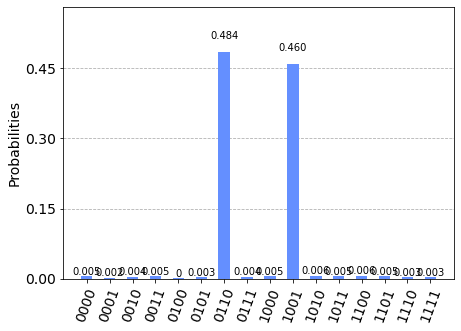

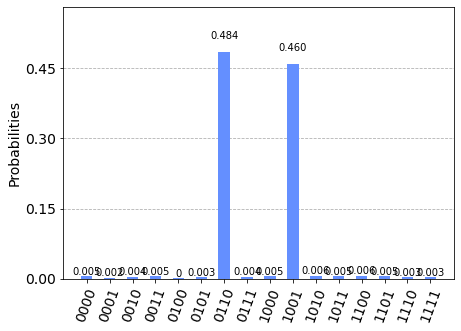

In [13]:
# Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())


What do these results mean? Are they correct?